In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import io
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load models used for prediction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# !pip install python-Levenshtein

In [69]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#load sentence dataset
df = pd.read_csv('CLEAN_sentences.csv', encoding = 'latin-1')

In [7]:
#load all metadata dataset
df_meta = pd.read_csv('sentence ordered var.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23836 entries, 0 to 23835
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23836 non-null  int64 
 1   ID          23836 non-null  int64 
 2   sentence    23836 non-null  object
 3   index2      23836 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 745.0+ KB


In [9]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23836 entries, 0 to 23835
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         23836 non-null  int64  
 1   ID                 23836 non-null  int64  
 2   index              23836 non-null  int64  
 3   Gender             23836 non-null  int64  
 4   Search term        23836 non-null  object 
 5   Current job role   23836 non-null  object 
 6   Desired job title  23812 non-null  object 
 7   Salary minimum     23631 non-null  object 
 8   Sal_goup           23631 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.6+ MB


In [10]:
#combining metadata and sentences
dftest = pd.concat([df_meta, df], axis =1)

In [11]:
dftest

,Unnamed: 0,ID,index,Gender,Search term,Current job role,Desired job title,Salary minimum,Sal_goup,Unnamed: 0,ID,sentence,index2
0,0,1001,0,1,aerospace,intern,propulsion test engineer,35000,2.0,0,1001,Education M.S.,0
1,1,1001,0,1,aerospace,intern,propulsion test engineer,35000,2.0,1,1001,"in Space and Astronautical Engineering, 8.6/ S...",0
2,2,1001,0,1,aerospace,intern,propulsion test engineer,35000,2.0,2,1001,"in Aeronautical Engineering, 7.2/ A.C.S.",0
3,3,1001,0,1,aerospace,intern,propulsion test engineer,35000,2.0,3,1001,"College of Engineering, Bangalore, India Relev...",0
4,4,1001,0,1,aerospace,intern,propulsion test engineer,35000,2.0,4,1001,Aeromech Precision Machiners.,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23831,23831,1698,682,0,robotics,robotics software engineer,robotics software engineer,50000,4.0,30,1698,cloud server.,679
23832,23832,1698,682,0,robotics,robotics software engineer,robotics software engineer,50000,4.0,31,1698,An autonomous mobile robot for warehouses and ...,679
23833,23833,1698,682,0,robotics,robotics software engineer,robotics software engineer,50000,4.0,32,1698,Robot uses ROS navigation stack.,679
23834,23834,1698,682,0,robotics,robotics software engineer,robotics software engineer,50000,4.0,33,1698,3D Mapping and Localization for VR : Created l...,679


In [12]:
dftest['Gender'].value_counts()

0    12077
1    11759
Name: Gender, dtype: int64

In [13]:
#extract only text and gender
dftest = dftest[['Gender', "sentence"]]

In [19]:
#define function to create vectors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [23]:
dftest.reset_index(inplace = True)

In [24]:
#create tagged documents
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
all_tagged = dftest.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['sentence']), tags=[r['index']]), axis=1)


In [25]:
len(all_tagged)

23836

In [26]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [27]:
#PV-DBOW model transformer
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(all_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 23836/23836 [00:00<00:00, 1783301.17it/s]


In [28]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 23836/23836 [00:00<00:00, 3968853.92it/s]


Wall time: 19.4 s


In [33]:
#construct matrix
sents = all_tagged.values
dbow  = pd.DataFrame()
for doc in sents:
    regressors = pd.DataFrame(model_dbow.infer_vector(doc.words, steps=20)).T
    dbow = pd.concat([dbow ,regressors ])                          

In [54]:
#PV-DM model tranformer
model_dm = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dm.build_vocab([x for x in tqdm(all_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 23836/23836 [00:00<00:00, 3263331.71it/s]


In [55]:

%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|███████████████████████████████████████████████████████████████████████| 23836/23836 [00:00<00:00, 3395327.90it/s]


Wall time: 44.9 s


In [56]:
#construct matrix
sents = all_tagged.values
dm = pd.DataFrame()
for doc in sents:
    regressors = pd.DataFrame(model_dm.infer_vector(doc.words, steps=20)).T
    dm = pd.concat([dm,regressors ])  

###  3.2.4 Predicton

#### Prediction with PV-DBOW

In [46]:
X_train, X_test, y_train, y_test = train_test_split(dbow , dftest.Gender, random_state=1,test_size=0.3)

In [47]:
y_train.sum()/len(y_train)

0.4918789331735091

In [48]:
y_test.sum()/len(y_test)

0.49671374632918475

In [49]:
logreg = LogisticRegression(n_jobs=-1, C=1e5,solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.4953153405118165
Testing F1 score: 0.46793454223794784


In [50]:
from sklearn import svm
#fit model
clf = svm.SVC(kernel='rbf', C = 0.05)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5032862536708153
Testing F1 score: 0.0


In [52]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#create model
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random",  random_state=42),
    bootstrap=True, n_jobs=-1, random_state=42)
#fit model
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5002097608726053
Testing F1 score: 0.42632423756019266


In [53]:
from sklearn.ensemble import RandomForestClassifier
#fit model
rnd_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.4901412389875542
Testing F1 score: 0.4638235294117647


#### Prediction of PV-DM

In [61]:
X_train, X_test, y_train, y_test = train_test_split(dm , dftest.Gender, random_state=1,test_size=0.3)

In [62]:
logreg = LogisticRegression(n_jobs=1, C=1e5,solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.4955950216752902
Testing F1 score: 0.46236398867193323


In [63]:
from sklearn import svm
#fit model
clf = svm.SVC(kernel='rbf', C = 0.05)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5032862536708153
Testing F1 score: 0.0


In [64]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#create model
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=20, random_state=42),
    n_estimators=300, bootstrap=True, n_jobs=-1, random_state=42)
#fit moel
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5027268913438679
Testing F1 score: 0.07395833333333333


In [65]:
from sklearn.ensemble import RandomForestClassifier
#fit model
rnd_clf = RandomForestClassifier(n_estimators=300, random_state=42,n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5092993986854986
Testing F1 score: 0.4692179700499168


### Review best scores for sentences (not included in text) 

In [34]:
#PV-DBOW matrix
dbow 

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.008130,-0.047105,-0.015149,0.018715,-0.026277,-0.028678,-0.039436,-0.002225,-0.031304,0.001997,...,-0.030074,0.024567,-0.063211,-0.009813,0.053179,-0.029576,0.023967,-0.005998,-0.055389,-0.059881
0,-0.014465,-0.128776,-0.042934,0.063080,-0.061765,-0.084509,-0.092172,-0.004057,-0.078395,-0.006406,...,-0.077549,0.069153,-0.144746,-0.018055,0.131015,-0.082557,0.045697,-0.022089,-0.137079,-0.161732
0,-0.007777,-0.090730,-0.031302,0.047619,-0.037105,-0.057260,-0.062403,-0.000366,-0.052577,-0.011494,...,-0.048095,0.052762,-0.093517,-0.012517,0.087762,-0.058611,0.031335,-0.019270,-0.087583,-0.109491
0,-0.039269,-0.114054,-0.030708,0.037297,-0.070463,-0.077520,-0.086181,-0.023114,-0.077273,0.039470,...,-0.098051,0.039587,-0.176078,-0.002768,0.133850,-0.065083,0.056800,-0.015025,-0.154666,-0.176248
0,-0.006672,-0.026889,-0.011514,0.006871,-0.015140,-0.009001,-0.019032,-0.009043,-0.015742,-0.005625,...,-0.019509,0.003093,-0.017542,0.004278,0.008446,-0.008469,0.002841,-0.003982,-0.026256,-0.023610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.003356,-0.024662,-0.007364,0.009221,-0.014437,-0.014698,-0.018932,-0.000598,-0.014330,0.000637,...,-0.016222,0.011337,-0.031208,-0.004305,0.025797,-0.014388,0.012643,-0.003027,-0.029479,-0.032666
0,-0.011024,-0.105633,-0.033336,0.046045,-0.059623,-0.066520,-0.087601,-0.004691,-0.067123,0.007025,...,-0.068783,0.054810,-0.137221,-0.020544,0.115954,-0.068736,0.050890,-0.012470,-0.125773,-0.132654
0,-0.006456,-0.079140,-0.023721,0.033410,-0.040443,-0.046187,-0.066895,-0.003902,-0.052297,0.002517,...,-0.049363,0.040251,-0.101998,-0.016735,0.088157,-0.052059,0.038825,-0.009587,-0.091523,-0.098930
0,-0.016581,-0.113506,-0.033153,0.047606,-0.062962,-0.070174,-0.093065,-0.005740,-0.074927,0.009224,...,-0.076355,0.055626,-0.151364,-0.020390,0.127600,-0.070982,0.055409,-0.014104,-0.138594,-0.146974


In [35]:
#Create dataframe for each sentence  and 10 other sentences that are most similar 
most_sim = pd.DataFrame()
for i in range (23836):
    sim = pd.DataFrame(model_dbow.docvecs.most_similar(i), columns = ['match_index','score'])
    sim['sen_index'] = i
    most_sim= pd.concat([most_sim, sim])

In [36]:
pd.DataFrame(model_dbow.docvecs.most_similar(5555))

,0,1
0,5805,0.999688
1,13304,0.999677
2,16686,0.999646
3,10289,0.999616
4,14643,0.999614
5,15481,0.999607
6,1893,0.999600
7,9596,0.999593
8,14969,0.999590
9,19239,0.999580


In [38]:
most_sim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238360 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   match_index  238360 non-null  int64  
 1   score        238360 non-null  float64
 2   sen_index    238360 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 7.3 MB


In [39]:
#merge sentence with gender information
matchscores = most_sim.merge(dftest[['index','Gender']], left_on= 'match_index', right_on = 'index' ).merge(dftest[['index','Gender']], left_on= 'sen_index', right_on = 'index' )

In [40]:
matchscores_male  = matchscores[matchscores['Gender_x'] ==0]

In [41]:
matchscores_female  = matchscores[matchscores['Gender_x'] ==1]

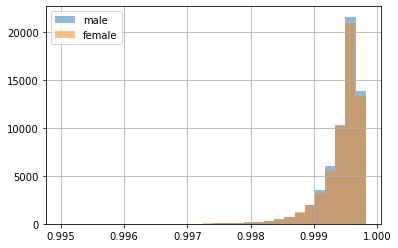

In [42]:
#plot histogram for sentences that are from a male CV, which matched to a second sentences with similarity score of above 0.995
#by gender of the 2nd sentence

matchscores_male[(matchscores_male.score>=0.995)&(matchscores_male.Gender_y ==0)].score.hist(bins = 30, alpha =0.5)
matchscores_male[(matchscores_male.score>=0.995)&(matchscores_male.Gender_y ==1)].score.hist(bins = 30,alpha =0.5)
plt.legend(['male','female'])

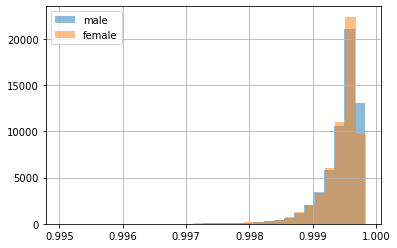

In [43]:
#plot histogram for sentences that are from a female CV, which matched to a second sentences with similarity score of above 0.995
#by gender of the 2nd sentence

matchscores_female[(matchscores_female.score>=0.995)&(matchscores_female.Gender_y ==0)].score.hist(bins = 30,alpha =0.5)
matchscores_female[(matchscores_female.score>=0.995)&(matchscores_female.Gender_y ==1)].score.hist(bins = 30,alpha =0.5)
plt.legend(['male','female'])

In [74]:
#proportion of female sentences
dftest.Gender.sum()/len(dftest)

0.49332941768753147

In [45]:
len(matchscores_female[(matchscores_female.Gender_y ==1)])

58644

### 3.2.3.2  Dimensionality reduction

In [75]:
#use DBOW embedding
doc2vec = dbow

#### PCA

In [77]:
#use PCA to reduce dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components = 20, whiten = True)
x = pca.fit_transform(doc2vec)
pca.explained_variance_ratio_

array([9.8704040e-01, 3.5647803e-03, 3.0691270e-03, 2.1417774e-03,
       1.9232513e-03, 1.2700672e-03, 3.7626122e-04, 1.9424084e-04,
       1.2137596e-04, 4.7268102e-05, 4.1264138e-05, 2.7410202e-05,
       1.1444469e-05, 9.4856268e-06, 6.4344604e-06, 5.9152935e-06,
       4.1788967e-06, 3.0545848e-06, 2.0402244e-06, 1.7882525e-06],
      dtype=float32)

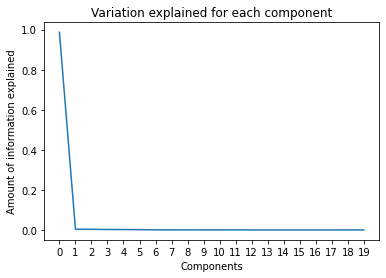

In [78]:
#plot information explained
plt.plot(pca.explained_variance_ratio_)
plt.title('Variation explained for each component')
plt.xticks(np.arange(20))
plt.ylabel("Amount of information explained")
plt.xlabel("Components")
plt.show()

In [79]:
#UIse PCA with 2 dimensions
pca = PCA(n_components = 2,whiten = True)
pca_x2 = pca.fit_transform(doc2vec)

In [80]:
pca = PCA(n_components = 2, whiten = True)
x = pca.fit_transform(doc2vec)
pca.explained_variance_ratio_

array([0.9870403 , 0.00356478], dtype=float32)

In [81]:
y= dftest.Gender

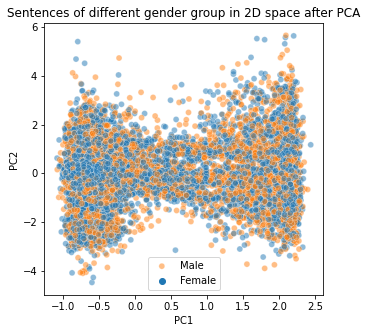

In [82]:
#plot data points of different gender
pca_2=pd.DataFrame(pca_x2, columns=['PC1', 'PC2'])
a = pd.concat([pca_2, y], axis = 1)
plt.figure(figsize=(5,5))
sns.scatterplot(data = a, x='PC1', y = 'PC2', hue = 'Gender', alpha = 0.5)
plt.title('Sentences of different gender group in 2D space after PCA')
plt.legend(['Male', 'Female'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### TSNE

In [86]:
from sklearn.manifold import TSNE

In [ ]:
#trying TSNE with 2 dimensions with perplexity = 10
tsne = TSNE(n_components = 2, perplexity = 10, random_state = 6, 
           )
tsne_x = tsne.fit_transform(doc2vec)

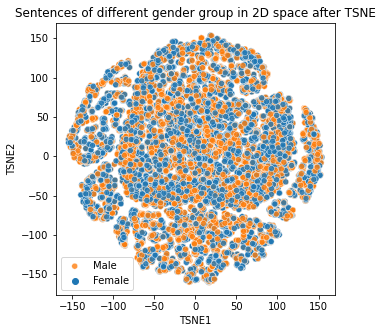

In [89]:
tsne_2=pd.DataFrame(tsne_x, columns=['TSNE1', 'TSNE2'])

b = pd.concat([tsne_2, dftest['Gender']], axis = 1)

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Gender",
    data=b,
    legend="full",
    alpha=0.8)
plt.title('Sentences of different gender group in 2D space after TSNE')
plt.legend(['Male', 'Female'])
plt.show()

In [98]:
#trying TSNE with 2 dimensions with perplexity = 5
tsne = TSNE(n_components = 2, perplexity = 5, random_state = 42)
tsne_5 = tsne.fit_transform(doc2vec)
#trying TSNE with 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 30, random_state = 42
tsne_30 = tsne.fit_transform(doc2vec)
#trying TSNE with 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 50, random_state = 42)
tsne_50 = tsne.fit_transform(doc2vec)

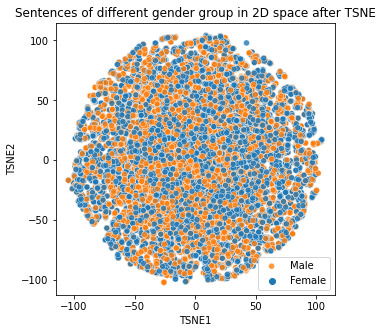

In [99]:
tsne_2=pd.DataFrame(tsne_5, columns=['TSNE1', 'TSNE2'])

b = pd.concat([tsne_2, dftest['Gender']], axis = 1)

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Gender",
    data=b,
    legend="full",
    alpha=0.8)
plt.title('Sentences of different gender group in 2D space after TSNE')
plt.legend(['Male', 'Female'])
plt.show()

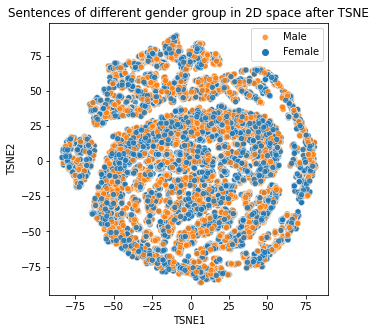

In [102]:
tsne_2=pd.DataFrame(tsne_30, columns=['TSNE1', 'TSNE2'])

b = pd.concat([tsne_2, dftest['Gender']], axis = 1)

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Gender",
    data=b,
    legend="full",
    alpha=0.8)
plt.title('Sentences of different gender group in 2D space after TSNE')
plt.legend(['Male', 'Female'])
plt.show()

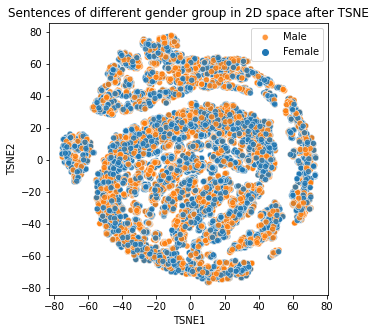

In [103]:
tsne_2=pd.DataFrame(tsne_50, columns=['TSNE1', 'TSNE2'])

b = pd.concat([tsne_2, dftest['Gender']], axis = 1)

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Gender",
    data=b,
    legend="full",
    alpha=0.8)
plt.title('Sentences of different gender group in 2D space after TSNE')
plt.legend(['Male', 'Female'])
plt.show()

### 3.2.3.3 Clustering

#### KMeans clustering

In [307]:
from sklearn.cluster import KMeans 

In [309]:
x= doc2vec

In [310]:
#running through n clusters from 0 to 10
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x)
    inertia.append(kmeanModel.inertia_)

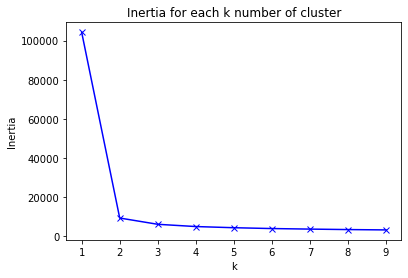

In [389]:
#plot interia by each n
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Inertia for each k number of cluster')

plt.show()

In [313]:
#2 clusters is the most appropriate
k_means2 = KMeans(init = "k-means++", n_clusters = 2, n_init = 12)
k_means2.fit(x)

KMeans(n_clusters=2, n_init=12)

In [315]:
k_means_labels_2 = k_means2.labels_

In [373]:
pca2kmn = pd.concat([a, pd.DataFrame(k_means_labels_2, columns = ['cluster_all'])], axis = 1)

In [374]:
a

,PC1,PC2,Gender
0,-0.110701,-0.292665,1
1,-0.698167,0.248839,1
2,1.185105,-1.189942,1
3,-0.919384,0.229359,1
4,0.058923,-0.109763,1
...,...,...,...
23831,-0.409967,0.056209,0
23832,-1.047861,-0.810296,0
23833,1.553539,0.900273,0
23834,-0.737399,-0.080687,0


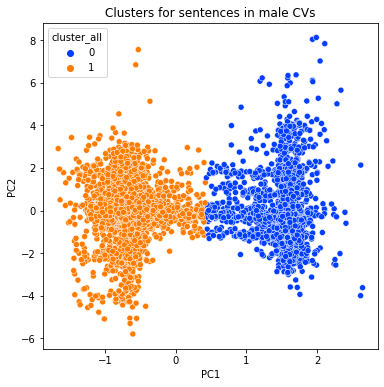

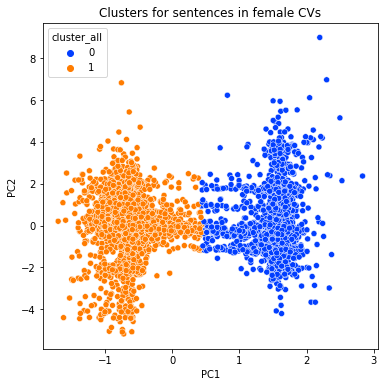

In [390]:
#to plot the two clusters on two dimensions on PCA

#plot male data points
plt.figure(figsize = (6,6))
sns.scatterplot(x='PC1',y='PC2',data = pca2kmn[pca2kmn['Gender']==0],hue='cluster_all', palette = "bright")
plt.title('Clusters for sentences in male CVs')
plt.show()

#plot female data points
plt.figure(figsize = (6,6))
sns.scatterplot(x='PC1',y='PC2',data =  pca2kmn[pca2kmn['Gender']==1],hue='cluster_all', palette = "bright")
plt.title('Clusters for sentences in female CVs')
plt.show()

In [378]:
tsne2kmn = pd.concat([b, pd.DataFrame(k_means_labels_2, columns = ['cluster_all'])], axis = 1)

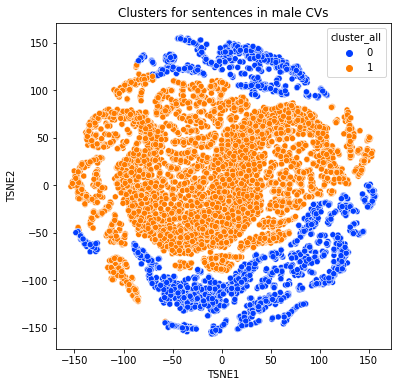

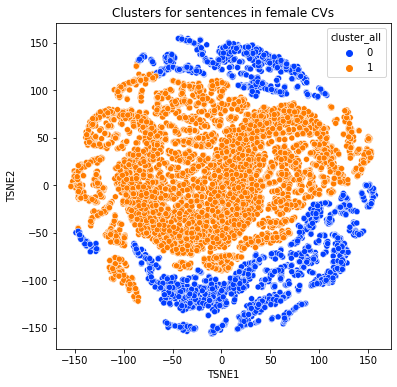

In [391]:
#to plot the two clusters on two dimensions on TSNE

#plot male data points
plt.figure(figsize = (6,6))
sns.scatterplot(x='TSNE1',y='TSNE2',data = tsne2kmn[tsne2kmn['Gender']==0],hue='cluster_all', palette = "bright")
plt.title('Clusters for sentences in male CVs')
plt.show()

#plot female data points
plt.figure(figsize = (6,6))
sns.scatterplot(x='TSNE1',y='TSNE2',data =  tsne2kmn[tsne2kmn['Gender']==1],hue='cluster_all', palette = "bright")
plt.title('Clusters for sentences in female CVs')
plt.show()

#### hirerachical clustering

In [392]:
import scipy.cluster.hierarchy as sch

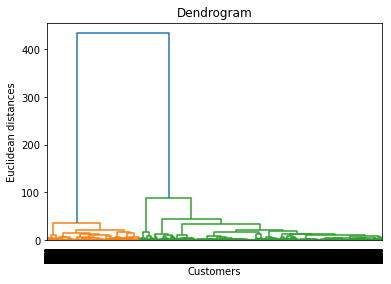

In [328]:
#draw dendrogram to find the best cluster number n
dendrogram = sch.dendrogram(sch.linkage(x, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [329]:
#fit clustering model with 2 clusters
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(x)

In [330]:
len(y_hc)

23836

In [331]:
hc_labels_all =y_hc

In [332]:
#create dataframe for visualisation
tsne2dhc2 = pd.concat([b, pd.DataFrame(hc_labels_all, columns = ['cluster_all'])], axis = 1)

In [333]:
tsne2dhc2

,TSNE1,TSNE2,Gender,cluster_all
0,-131.435867,62.219444,1,0
1,5.813142,-82.023338,1,0
2,-21.059628,152.922623,1,1
3,103.657982,57.049725,1,0
4,-116.197205,40.981373,1,0
...,...,...,...,...
23831,-40.125542,70.422943,0,0
23832,103.678276,23.740562,0,0
23833,60.429874,-98.313675,0,1
23834,24.546988,36.953659,0,0


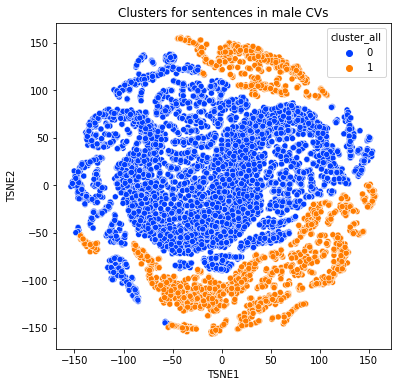

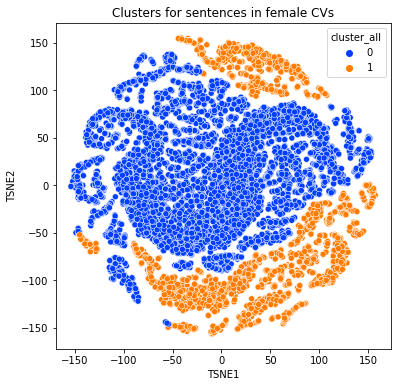

In [393]:
#plot clusters by gender
plt.figure(figsize = (6,6))
#sns.set_palette("husl", 8)
sns.scatterplot(x='TSNE1',y='TSNE2',data = tsne2dhc2[tsne2dhc2['Gender']==0],hue='cluster_all', palette = "bright")
plt.title('Clusters for sentences in male CVs')
plt.show()

plt.figure(figsize = (6,6))
sns.scatterplot(x='TSNE1',y='TSNE2',data = tsne2dhc2[tsne2dhc2['Gender']==1],hue='cluster_all', palette = "bright")
plt.title('Clusters for sentences in female CVs')
plt.show()

In [394]:
a

,PC1,PC2,Gender
0,-0.110701,-0.292665,1
1,-0.698167,0.248839,1
2,1.185105,-1.189942,1
3,-0.919384,0.229359,1
4,0.058923,-0.109763,1
...,...,...,...
23831,-0.409967,0.056209,0
23832,-1.047861,-0.810296,0
23833,1.553539,0.900273,0
23834,-0.737399,-0.080687,0


##### an attempt to predict gender on PCA reduced matrix

In [91]:
X_train, X_test, y_train, y_test = train_test_split(a[['PC1','PC2']], a.Gender, random_state=1,test_size=0.3)

In [92]:
len(X_test)

7151

In [93]:
logreg = LogisticRegression(n_jobs=1, C=1e5,solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5028667319256048
Testing F1 score: 0.15778251599147122


In [94]:
from sklearn import svm
#fit model
clf = svm.SVC(kernel='rbf', C = 0.05)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5028667319256048
Testing F1 score: 0.0970281940563881


In [95]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#create model
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=20, random_state=42),
    n_estimators=300, bootstrap=True, n_jobs=-1, random_state=42)
#fit moel
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5007691231995525
Testing F1 score: 0.1389290882778582


In [96]:
from sklearn.ensemble import RandomForestClassifier
#fit model
rnd_clf = RandomForestClassifier(n_estimators=300, random_state=42,n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred)))

Testing accuracy 0.5013284855264998
Testing F1 score: 0.48749640701350966
